# 1. *Imports*

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%matplotlib inline

In [ ]:
! pip install tensorboard
# ! tensorboard --logdir=runs

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
from PIL import Image
import os
import os.path

from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

from __future__ import absolute_import
from __future__ import unicode_literals
from __future__ import print_function
from __future__ import division
import math
import gc
! pip install colorama
from colorama import Fore

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda:0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# % cd /content/drive/MyDrive/my_code/25_pso_second_step/cond_with_rotation
% cd /content/drive/MyDrive/cond_with_rotation

/content/drive/.shortcut-targets-by-id/1y7SsmJxTn15Ta0N-CvQfNP3_Ev2SWlrb/cond_with_rotation


In [ ]:
from dataloader.dataloader import CIFAR10_modified , CIFAR100_modified
from visulization.dataset_vis import rotated_dataset_plot
from model.dense import CondenseNet

# 2. Parameters

In [ ]:
reslut_name = 'condens_ss10'
resume_checkpoint =False
path = 'result/{}'.format(reslut_name)
if not os.path.exists(path):
   os.mkdir(path)

##################
# training parameter
batch_size = 32
weight_pr = 1
learning_rate = 0.1
momentum = 0.9
W_decay  = 0
lr_type = 'cosine'
##################


unsupervised_training =True
main_dataset  = 'Cifar10'
pre_text_dataset = 'Cifar10'

##############################
# CondenseNet parameters
model_parm ={}
model_parm['stages']  =  [14,14,14]
model_parm['data']  = 'cifar10'
model_parm['growth'] =[8,16,32]
model_parm['num_classes'] = 10
model_parm['group_1x1'] = 4
model_parm['group_3x3'] = 4
model_parm['bottleneck'] = 4
model_parm['condense_factor'] =4
model_parm['dropout_rate'] = 0
###############################

##################### saving parameters as a csv file

info = model_parm
info['batch_size'] = batch_size
info['weight_pr '] = weight_pr 
info['learning_rate']  = learning_rate 
info['momentum']  =  momentum
info['W_decay']  =  W_decay
df = pd.DataFrame(info)
df_name = 'result/{}/run_info.csv'.format(reslut_name)
df.to_csv(df_name)

In [ ]:
transform = transforms.Compose(    [transforms.ToTensor(),transforms.Normalize(mean=[0.4914, 0.4824, 0.4467], std=[0.2471, 0.2435, 0.2616])])
if main_dataset  == 'Cifar10':
  trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                          download=True, transform=transform)
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True)
  testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)
  testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False)

  classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
if unsupervised_training:
  if pre_text_dataset == 'Cifar100':
    pretext_data = CIFAR100_modified(root='./data', train=True,download=True, transform=transform)
    pretext_data_loader = torch.utils.data.DataLoader(pretext_data, batch_size=batch_size, shuffle=True)
  elif  pre_text_dataset == 'Cifar10':
    pretext_data = CIFAR10_modified(root='./data', train=True,download=True, transform=transform)
    pretext_data_loader = torch.utils.data.DataLoader(pretext_data, batch_size=batch_size, shuffle=True)
# plotting some sample
  # rotated_dataset_plot(pretext_data_loader)

Files already downloaded and verified


# 3.Model

In [ ]:
def load_checkpoint(checkpoint_path,model_filename):
    check = os.path.join(path, checkpoint_path, model_filename)
    print("=> loading checkpoint '{}'".format(check))
    state = torch.load(checkpoint_path)
    print("=> loaded checkpoint '{}'".format(check))
    return state

In [ ]:
my_model = CondenseNet( model_parm['stages'] ,model_parm['data'], model_parm['growth'],model_parm['num_classes'],model_parm['group_1x1'],model_parm['group_3x3'],model_parm['bottleneck'],model_parm['condense_factor'],model_parm['dropout_rate'] )
my_model.to(device)


CondenseNet(
  (features): Sequential(
    (init_conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (denseblock_1): _DenseBlock(
      (denselayer_1): _DenseLayer(
        (conv_1): LearnedGroupConv(
          (norm): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (conv_2): Conv(
          (norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv): Conv2d(32, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=4, bias=False)
        )
      )
      (denselayer_2): _DenseLayer(
        (conv_1): LearnedGroupConv(
          (norm): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv): Conv2d(24, 32, kernel_size=(1, 1

In [ ]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(my_model.parameters(), lr=0.0001)
# optimizer = optim.SGD(my_model.parameters(), lr=learning_rate, momentum=moment,weight_decay=W_decay)
optimizer = torch.optim.SGD(my_model.parameters(), lr=learning_rate,
                                momentum=momentum,
                                weight_decay=W_decay,
                                nesterov=True)

In [ ]:
start_epoch = 0
if resume_checkpoint:
        checkpoint_path = 'result/{}'.format(reslut_name)
        list_files = os.listdir(checkpoint_path)
        model_filename = None
        for i, s in enumerate(list_files):        
           if 'checkpoint' in s and '.pt' in s:
             model_filename = list_files[i]
        if  (model_filename is None):
          print('there is no model to load')
        else :
          checkpoint = load_checkpoint(checkpoint_path,model_filename)
          if checkpoint is not None:
              start_epoch = checkpoint['epoch'] + 1
              Loss = checkpoint['loss']
              my_model.load_state_dict(checkpoint['model_state_dict'])
              optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# 4. Model training

In [ ]:
def adjust_learning_rate(optimizer, epoch, EPOCHS,learning_rate ,batch=None,
                         nBatch=None, method='cosine'):
    if method == 'cosine':
        T_total = EPOCHS  * nBatch
        T_cur = (epoch % EPOCHS ) * nBatch + batch
        lr = 0.5 * learning_rate * (1 + math.cos(math.pi * T_cur / T_total))
    elif method == 'multistep':
       
            lr, decay_rate = learning_rate, 0.1
            if epoch >= EPOCHS * 0.75:
                lr *= decay_rate**2

            elif epoch >= EPOCHS * 0.5:
                lr *= decay_rate

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

In [ ]:
def train_one_epoch(epoch,  total_bach,lr_type,optimizer,EPOCHS,learning_rate ):

    running_loss_1 = 0.
    last_loss_1 = 0.
    running_loss_2 = 0.
    last_loss_2 = 0.
    acc = 0
    tot = 0
    cor = 0
    acc2 = 0
    tot2 = 0
    cor2 = 0
    training_loss = 0
    running_lr = None
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(trainloader,0):

        lr = adjust_learning_rate(optimizer, epoch,EPOCHS = EPOCHS,learning_rate = learning_rate, batch=i,
                                  nBatch=total_bach, method=lr_type )
        if running_lr is None:
            running_lr = lr


      # Zero your gradients for every batch!
        optimizer.zero_grad()     
        image,label = data
        image,label = image.to(device),label.to(device)
        # Make predictions for this batch
        outputs,_ = my_model(image)            
        loss_1 = criterion(outputs,label) 
        running_loss_1 += float(loss_1.item() )       
        _, pr= torch.max( outputs.data, 1) 
        tot +=float(label.size(0)) 
        cor += float((pr ==  label).sum().item())
        acc = 100 * cor / tot    
        
        if unsupervised_training:
          image_r,rotation = next(iter(pretext_data_loader))            
          image_r,rotation =  image_r.to(device),rotation.to(device)      
          _,outputs_r = my_model( image_r) 
          loss_2 = criterion(outputs_r,rotation)
          running_loss_2 += float(loss_2.item())
          loss =  loss_1 + weight_pr *loss_2            
          _, pr2= torch.max(outputs_r.data, 1)
          _, real2= torch.max(rotation.data, 1)
          tot2 +=float(rotation.size(0)) 
          cor2 +=float((pr2 == real2).sum().item()) 
          acc2 = 100 * cor2 / tot2
        else:
          loss =  loss_1

        loss.backward()      
        optimizer.step()      

        last_loss_1 += float(loss_1) 
        last_loss_2 += float(loss_2)
        if i % 300 == 299:

          R1 = running_loss_1/300
          R2 =running_loss_2/300
          print(Fore.BLUE,'{}/ {} train_l1: {} train_l2: {}, accu is {}  pretex_accu is {} time is {}'.format(i + 1,total_bach, '%.5f' %(R1),'%.5f' %(R2),'%.4f' %acc,'%.4f' %acc2,'%.5f' %(time.time() - start_time)))
          
          running_loss_1 = 0.
          running_loss_2 = 0. 

        
    PATH ='result/{}/checkpoints{}.pt'.format(reslut_name,epoch)
   
    torch.save({
                'epoch': epoch,
                'model_state_dict': my_model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss,
                }, PATH)
    if epoch != 0:
      PATH_prev ='result/{}/checkpoints{}.pt'.format(reslut_name,epoch-1)
      os.remove(PATH_prev)

    return (last_loss_1/total_bach),(last_loss_2/total_bach),acc,acc2,running_lr

In [ ]:
def save_result(train_loss_main,test_loss_main,train_accuracy_main,test_accuracy_main):
    E = [i for i in range(len(train_loss_main))]
    t_train_loss_main = [train_loss_main[i]  for i  in range(len(train_loss_main))]
    s_test_loss_main =  [test_loss_main[i]  for i  in range(len(test_loss_main))]
    t_train_accuracy_main  = [train_accuracy_main [i]  for i  in range(len(train_accuracy_main ))]
    s_test_accuracy_main =  [test_accuracy_main[i] for i  in range(len(test_accuracy_main))]
    t_train_accuracy_pre = [train_accuracy_pre[i]  for i  in range(len(train_loss_main))]
    
    fig, (axs, ax2,ax3) = plt.subplots(3)
    axs.plot(E, t_train_loss_main)
    axs.plot(E,s_test_loss_main)    
    axs.set_xlabel('epoch')
    axs.set_ylabel('loss')
    axs.grid(True)
    ax2.plot(E, t_train_accuracy_main )
    ax2.plot(E,s_test_accuracy_main)    
    ax2.set_xlabel('epoch')
    ax2.set_ylabel('accuracy')
    ax2.grid(True)  
    ax3.plot(E, t_train_accuracy_pre )
    ax3.set_xlabel('epoch')
    ax3.set_ylabel('pretext_accuracy')

    fig.tight_layout()
    image_name ='result/{}/plots.png'.format(reslut_name)
    plt.savefig(image_name )

    dict = {'acc_train': t_train_accuracy_main, 
            'acc_test': s_test_accuracy_main,
            'loss_train': t_train_loss_main,
            'loss_test':s_test_loss_main}
    df = pd.DataFrame(dict)
    df_name = 'result/{}/results.csv'.format(reslut_name)
    df.to_csv(df_name)
    del df
    del fig
    del t_train_loss_main
    del  s_test_loss_main 
    del t_train_accuracy_main
    del s_test_accuracy_main
    del t_train_accuracy_pre

In [ ]:
def memReport():
    # for obj in gc.get_objects():
    #     if torch.is_tensor(obj):
    #         print(type(obj), obj.size())
    gc.collect()

EPOCH 1:
 300/ 1563 train_l1: 2.05929 train_l2: 1.36081, accu is 28.0000  pretex_accu is 32.3333 time is 88.54405
 600/ 1563 train_l1: 1.53729 train_l2: 1.24856, accu is 35.8177  pretex_accu is 39.5625 time is 166.55755
 900/ 1563 train_l1: 1.32419 train_l2: 1.19332, accu is 41.2812  pretex_accu is 44.0347 time is 244.62376
 1200/ 1563 train_l1: 1.14236 train_l2: 1.15861, accu is 45.7526  pretex_accu is 47.2656 time is 322.50837
 1500/ 1563 train_l1: 1.05514 train_l2: 1.13105, accu is 49.2125  pretex_accu is 49.8750 time is 400.60497
 for main taks,loss_test 1.0353156520535771,..... acc_test 64.33
EPOCH 2:
 300/ 1563 train_l1: 0.90989 train_l2: 1.10972, accu is 68.2292  pretex_accu is 62.7708 time is 516.77693
 600/ 1563 train_l1: 0.86735 train_l2: 1.09759, accu is 68.9479  pretex_accu is 63.2396 time is 594.37434
 900/ 1563 train_l1: 0.83186 train_l2: 1.08422, accu is 69.4167  pretex_accu is 63.8924 time is 672.18857
 1200/ 1563 train_l1: 0.75517 train_l2: 1.07858, accu is 70.4062  pr

KeyboardInterrupt: ignored

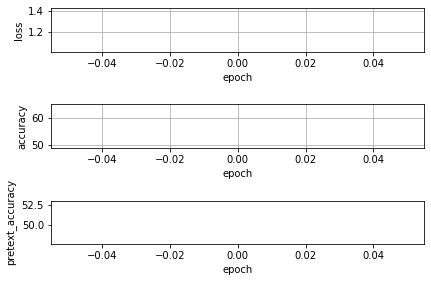

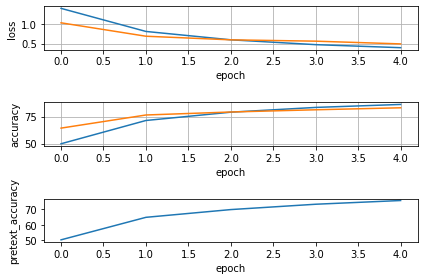

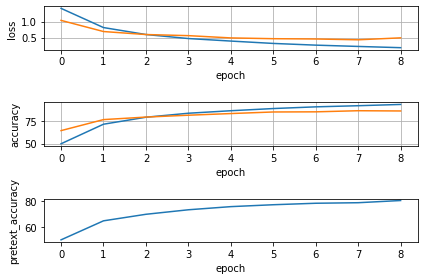

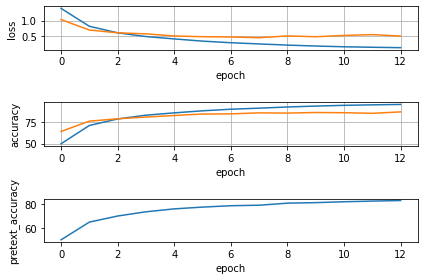

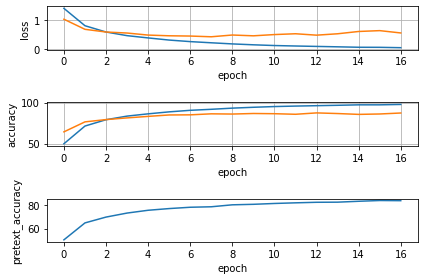

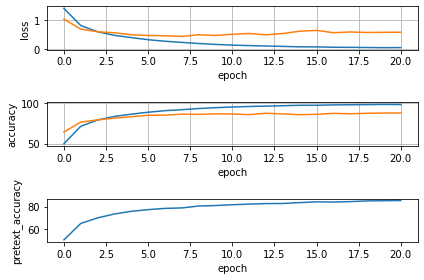

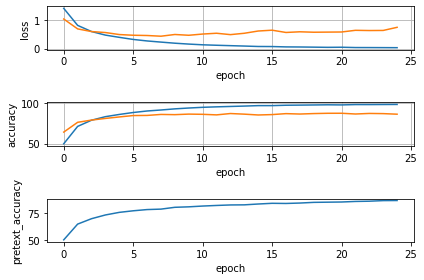

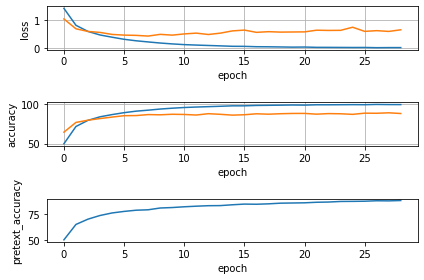

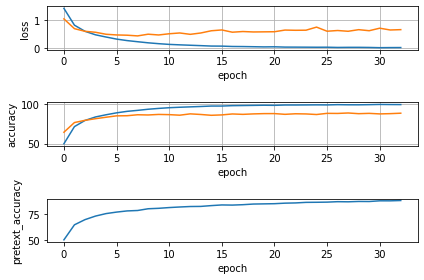

In [ ]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
total_bach = len(trainloader)
total_batch_test = len(testloader)
writer = SummaryWriter('result/{}/{}'.format(reslut_name,timestamp))

import time
start_time = time.time()

EPOCHS = 200
best_vloss = 1_000_000.

train_loss_main =[]
train_accuracy_main =[]

train_loss_pre =[]
train_accuracy_pre =[]

test_loss_main =[]
test_accuracy_main =[]


for epoch in range(start_epoch,EPOCHS):

    print('EPOCH {}:'.format(epoch+1))

    # Make sure gradient tracking is on, and do a pass over the data
    my_model.train(True) 
   

    L1, L2,acc,acc2,lr= train_one_epoch(epoch,total_bach,lr_type,optimizer,EPOCHS,learning_rate)
    train_loss_main.append(L1)    
    train_accuracy_main.append(acc)
    if unsupervised_training:
      train_loss_pre.append(L2)
      train_accuracy_pre.append(acc2)
 
    running_vloss = 0.0
    correct =0
    total = 0.
    my_model.train(False) 
    for i, vdata in enumerate(testloader ):
        with torch.no_grad():
          v_image, vlabels = vdata
          v_image, vlabels =  v_image.to(device), vlabels.to(device)
          voutputs,_  =  my_model(v_image)          
                      
          vloss = criterion(voutputs, vlabels)
          running_vloss += float(vloss)

          _, predicted = torch.max(voutputs.data, 1)
          # _, real_label = torch.max(vlabels.data, 1)
          total +=   float(vlabels.size(0)) 
          correct += float((predicted == vlabels.data).sum().item())
         
    accuracy = 100 * correct / total
    avg_vloss = running_vloss / (total_batch_test)
    test_loss_main.append(avg_vloss)
    test_accuracy_main.append(accuracy)

    writer.add_scalars('Training vs. Validation Loss',
           { 'Training' : L1, 'Validation' : avg_vloss },
                    epoch + 1)
    
    writer.add_scalars('Training vs. Validation accuracy',
           { 'Training' : acc, 'Validation' : accuracy },
                    epoch + 1)
    writer.add_scalars('pretext_loss',
           { 'Training' : L2},
                    epoch + 1)
    writer.add_scalars('pretext_accu',
           { 'Training' : acc2},
                    epoch + 1)
    
    print(Fore.GREEN,'for main taks,loss_test {},..... acc_test {}'.format(avg_vloss, accuracy))   
  
    memReport()
    if epoch %4 ==0:
      save_result(train_loss_main,test_loss_main,train_accuracy_main,test_accuracy_main)

       # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'result/{}/best_model.pt'.format(reslut_name)
        torch.save(my_model.state_dict(),model_path)

writer.close()